# Computing Wasserstein distances for the uncertain shock location

At $T=0.2$, the exact solution is given as 

$$u(y;x,T)=\begin{cases}1&x\leq \frac{1}{2}(1+T)+y\\
0&\text{otherwise}\end{cases}\qquad x\in[0,1], y\in[-0.1,0.1].$$

Let $\mu_T$ be the law of $u(\cdot;\cdot,T)$ (ie. the statistical solution). 

Our approximate solution is an esemble of Dirac deltas centered at FVM solutions

$$\mu^{\Delta x,M}_T=\frac{1}{M}\sum_{k=1}^M \delta_{u^{\Delta x}_k(\cdot,t)}$$

After some disintegration and support considerations, we arrive at the final formula for the Wasserstein distance should be

$$W_1(\mu_T,\mu^{\Delta x,M}_T)=\int_{-0.1}^{0.1} \|u_{\bar{k}(y)}^{\Delta x}-u(y,\cdot,T)\|_{L^1([0,1])}\frac{1}{0.2}\; dy$$

where
$$\bar{k}(y) = \lfloor \frac{M(y+0.1)}{0.2}\rfloor$$
where the samples are sorted according to 

$$ u^{\Delta x}_k\leq u^{\Delta x}_l\Leftrightarrow u^{\Delta x}_k(x_i)\leq u^{\Delta x}_l(x_i)\qquad \text{for all }i=1,\ldots,N_{\Delta x}.$$

That is, we divide the interval $[-0.1,0.1]$ into $M$ pieces, and assign $u_1$ the first interval, $u_2$ the second interval, and so on.

**Claim** (Not requiring Miracle): The measure defined by
$$f\mapsto \int_{-0.1}^{0.1}f(u(y,\cdot,T),u^{\Delta x}_{\bar{k}(y)})\frac{1}{0.2}\;dy$$
is in $\Pi(\mu_t,\mu_t^{\Delta x,M})$.

**Claim** (Miracle): The above defined measure is optimal. The proof goes through disintegrating the measure.

![Miracle](miracle.jpg)

## Numerical algorithm

1. Sort the samples according to (see next sections for when this is well-defined)
$$ u^{\Delta x}_k\leq u^{\Delta x}_l\Leftrightarrow u^{\Delta x}_k(x_i)\leq u^{\Delta x}_l(x_i)\qquad \text{for all }i=1,\ldots,N_{\Delta x}$$
2. Discretize the parameter space:
$$Y=[-0.1, 0.1] =\bigcup_{y=1}^{N_y} [y_i,y_{i+1}]\qquad \text{where }|y_i-y_{i+1}|=\Delta y\approx \Delta x/8$$
5. For $y = y_1,\ldots,y_{N_y}$:

  a) Compute exact solution $u(y,x_j,T)$ for $j=1,\ldots,N_{\Delta x}$
  
  b) Compute current distance:
  $$d^{k}_y=\sum_i |u(y,x_i,T)-u^{\Delta x}_{\bar{k}(y)}(y,x_i,T)|\Delta y$$
  
  e) Add contribution to the distance
  
  $$ distance \leftarrow distance + d^k(y)\Delta y$$


In [1]:


import numpy as np
import plot_info

import matplotlib
matplotlib.rcParams['errorbar.capsize'] = 3
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import functools
import matplotlib2tikz
import alsvinn

In [2]:
%%writefile shock_location.py
# Initial data file
Y = 0.2*X - 0.1
if x <= 0.5 + Y:
    u = 1.0
else:
    u = 0.0

Overwriting shock_location.py


In [3]:
%%writefile shock_location.xml
<config>
<fvm>
  <name>
    shocklocation
  </name>
  <platform>cpu</platform>
  <grid>
    <lowerCorner>0 0 0</lowerCorner>
    <upperCorner>1 0 0</upperCorner>
    <dimension>32 1 1</dimension>
  </grid>
  <boundary>neumann</boundary>
  <flux>godunov</flux>
  <endTime>.2</endTime>
  <equation>burgers</equation>
  <reconstruction>weno2</reconstruction>
  <cfl>auto</cfl>
  <integrator>auto</integrator>
  <initialData>
    <python>shock_location.py</python>
    <parameters>
      <parameter>
        <name>X</name>
        <length>1</length>
        <value>0</value>
      </parameter>
    </parameters>
  </initialData>
  <writer>
    <basename>shock_location</basename>
    <type>netcdf</type>
    <numberOfSaves>1</numberOfSaves>
  </writer>
</fvm>
<uq>
  <samples>1</samples>
  <generator>auto</generator>
  <parameters>
    <parameter>
      <name>X</name>
      <length>1</length>
      <type>uniform</type>
    </parameter>
  </parameters>
  <stats>
  </stats>

</uq>
</config>


Overwriting shock_location.xml


In [4]:
def compare(u1, u2):
    """
    Compares two numerical solutions against eachother.
    
    We say that 
    
         u1 <= u2
    
    if 
        
        u1[j] <= u2[j]     for all j in range(len(u1))
    """
    
    if not (u1<=u2).all() and not (u2<=u1).all():
        raise Exception("Not well ordered!")
    if (u1 <= u2).all():
        return -1
    else:
        return 1
    

# Some ordering tests

The main point below is that if the use WENO2 (meaning third order reconstruction), the results are not well-ordered according to our ordering definition above.

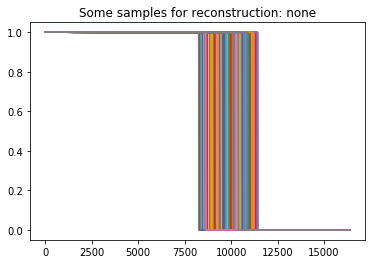

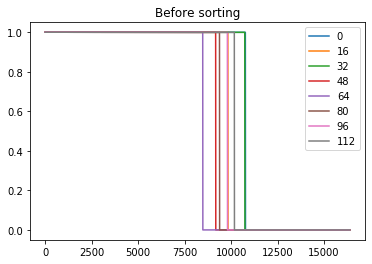

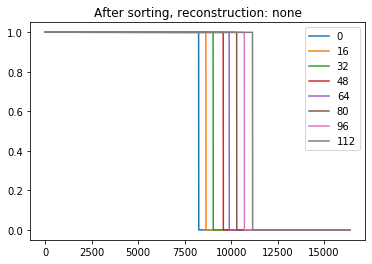

Everything went well


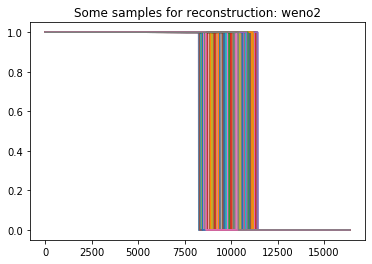

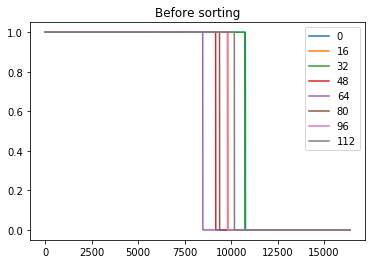

Failed sorting samples with reconstruction: weno2


In [5]:


def test(reconstruction):
    resolution = 2**14
    number_of_samples=128
   
    r = alsvinn.run(base_xml='shock_location.xml',
                   reconstruction=reconstruction,
                   dimension=[resolution, 1, 1],
                   samples=number_of_samples,
                   uq=True)
    data = []
    for k in range(number_of_samples):
        plt.plot(r.get_data('u', timestep=0, sample=k))
        data.append(r.get_data('u', timestep=0, sample=k))
    plt.title(f"Some samples for reconstruction: {reconstruction}")
    plt.show()
    
    for d in range(0,len(data),16):
        plt.plot(data[d],label='%d' % d)
    plt.legend()
    plt.title('Before sorting')
    plt.show()
    try:
        data = sorted(data,key=functools.cmp_to_key(compare))
    except:
        print(f"Failed sorting samples with reconstruction: {reconstruction}")
        return
    
    for d in range(0,len(data),16):
        plt.plot(data[d],label='%d' % d)
    plt.legend()
    plt.title(f"After sorting, reconstruction: {reconstruction}")
    plt.show()
    print("Everything went well")

# First we try with the low order:
test("none")

# Then with the high order:
test("weno2")

In [6]:
def runAndSort(resolution, samples, experiment=0, base_xml = 'shock_location.xml'):
    sample_start = experiment * samples
    
    r = alsvinn.run(base_xml = base_xml,
            samples=samples,
            sampleStart=sample_start,
            reconstruction='none',
            uq=True,
            dimension=[int(resolution), 1, 1]
        )
    
    
    data = []
    for k in range(sample_start, sample_start+samples):
        d = r.get_data('u', sample=k, timestep=0)
        data.append(d)
    data = sorted(data,key=functools.cmp_to_key(compare))
    return data

In [7]:
def upscale(d,N):
    while d.shape[0] < N:
        d = repeat(d,2,0)
    return d
def l1distance(dataSample, shockLocation):
    
    x = np.linspace(0,1,dataSample.shape[0])
    uExact = x <= shockLocation
    
    return np.sum(abs(dataSample - uExact))/dataSample.shape[0]

def l2distance(dataSample, shockLocation):
    
    x = np.linspace(0,1,dataSample.shape[0])
    uExact = x <= shockLocation
    
    return np.sqrt(np.sum(abs(dataSample - uExact)**2)/dataSample.shape[0])

def wassersteinDistance(data, T):
    shockLocation = lambda y: 0.5 + 0.5*T + y
    M = len(data)
    Y = np.linspace(-1/10.,1/10., 128*data[0].shape[0])
   
    dy = Y[1]-Y[0]
    
    distance = 0
    
    for (ny, y) in enumerate(Y):
        s = shockLocation(y)
        
        currentDistance = l1distance(data[min(int((y+0.1)/0.2*M),M-1)], s)
        distance += currentDistance * dy
    return distance
    

##############################################################################################################################################################################################################################################################



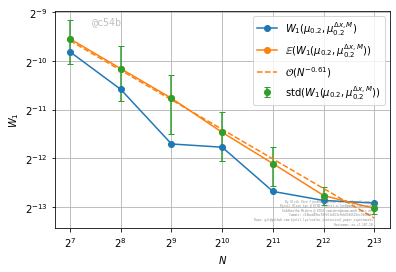

In [8]:
import sys
def estimateConvergence(resolutions, errors, color='green'):
    poly = np.polyfit(np.log(resolutions), np.log(errors), 1)
    
    plt.loglog(resolutions, np.exp(poly[1])*resolutions**(poly[0]),
               '--',label='$\\mathcal{O}(N^{%.2f})$' % poly[0],
              color=color)
    
def runExperiments(resolution):
    distances = []
    for experiment in range(0,(4*4096)//resolution):
        sys.stdout.write("#")
        sys.stdout.flush()
        data = runAndSort(resolution, resolution, experiment)
        distance = wassersteinDistance(data,0.2)
        distances.append(distance)
    errorAvg = np.mean(distances)
    errorStd = np.std(distances)
    return errorAvg, errorStd

resolutions = [128,256,512,1024,2048,4096,2*4096]
errors = []
mean_errors = []
std_errors = []

for resolution in resolutions:
    data = runAndSort(resolution, resolution)
    distance = wassersteinDistance(data,0.2)
    
    errors.append(distance)
    
    avgError, stdError = runExperiments(resolution)
    
    mean_errors.append(avgError)
    std_errors.append(stdError)
    
plt.loglog(resolutions, errors,'-o',label='$W_1(\\mu_{0.2},\\mu_{0.2}^{\\Delta x,M})$')
line_ref = plt.loglog(resolutions, mean_errors,'-o',label='$\\mathbb{E}(W_1(\\mu_{0.2},\\mu_{0.2}^{\Delta x,M}))$')
plt.errorbar(resolutions, mean_errors, 
             yerr=std_errors,
             fmt='o',label='$\\mathrm{std}(W_1(\\mu_{0.2},\\mu_{0.2}^{\\Delta x,M}))$')
estimateConvergence(resolutions, mean_errors, color=line_ref[0].get_color())
plt.grid('on')
plt.gca().set_xscale('log', basex=2)
plt.gca().set_yscale('log', basey=2)
plt.xlabel("$N$")
plt.ylabel("$W_1$")
plt.legend()

plot_info.showAndSave('wasserstein_shock')

# Midpoint rule

## Configuration files

In [9]:
%%writefile shock_location_midpoint.xml
<config>
<fvm>
  <name>
    shock_location_midpoint
  </name>
  <platform>cpu</platform>
  <grid>
    <lowerCorner>0 0 0</lowerCorner>
    <upperCorner>1 0 0</upperCorner>
    <dimension>32 1 1</dimension>
  </grid>
  <boundary>neumann</boundary>
  <flux>godunov</flux>
  <endTime>.2</endTime>
  <equation>burgers</equation>
  <reconstruction>weno2</reconstruction>
  <cfl>auto</cfl>
  <integrator>auto</integrator>
  <initialData>
    <python>shock_location.py</python>
    <parameters>
      <parameter>
        <name>X</name>
        <length>1</length>
        <value>0</value>
      </parameter>
    </parameters>
  </initialData>
  <writer>
    <basename>shock_location</basename>
    <type>netcdf</type>
    <numberOfSaves>1</numberOfSaves>
  </writer>
</fvm>
<uq>
  <samples>1</samples>
  <generator>auto</generator>
  <parameters>
    <parameter>
      <name>X</name>
      <length>1</length>
      <type>uniform1d</type>
    </parameter>
  </parameters>
  <stats>
  </stats>

</uq>
</config>


Writing shock_location_midpoint.xml


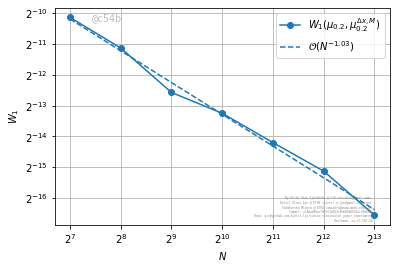

In [10]:

resolutions = [128,256,512,1024,2048,4096,2*4096]
errors = []

for resolution in resolutions:
    data = runAndSort(resolution, resolution, base_xml = 'shock_location_midpoint.xml')
    
    distance = wassersteinDistance(data, 0.2)
    
    errors.append(distance)
    
line_ref = plt.loglog(resolutions, errors,'-o',label='$W_1(\\mu_{0.2},\\mu_{0.2}^{\\Delta x,M})$')

estimateConvergence(resolutions, errors, color=line_ref[0].get_color())
plt.grid('on')
plt.gca().set_xscale('log', basex=2)
plt.gca().set_yscale('log', basey=2)
plt.xlabel("$N$")
plt.ylabel("$W_1$")
plt.legend()

plot_info.showAndSave('wasserstein_shock_uniform')